In [1]:
from Uncertainty import *
from uncertaintyMetric import *
from utils import *

K.clear_session()
check_tensorflow_gpu()

Checking Tensorflow Version:
Tensorflow built with CUDA? True
Tensorflow version: 2.6.2
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
results = proxy(ncol_data=15, rom_obj=Ridge(), rom_data=Ridge(), nMCSamples=1000, nDataRealization=50)
print('UQ Reudction', results.value)

Measure Type: 1 | Data File Name: run_presWAT.his | Description: Pressure | nColData: [15] | HM-epsilon: 0.002
Build the ROMs for data points: Done!
Build the ROMs for objective of interests: Done!
Evaluating Monte Carlo samples: ing... ing ...
Evaluate the Monte Carlo samples: Done!
Generate synthetic monitoring data: Done!
 Calculating uncertainty reduction

Data assimilation is done!
UQ Reudction -18128188.389520474


***

In [7]:
# General settings
Main_Directory   = os.getcwd()
Data_Directory   = os.path.join(Main_Directory, 'data')
titles           = ['.', 'Pressure', 'CO2 Saturation (l)', 'Temperature', 'Pressure + CO2 Saturation']
unc_params       = ['perm4', 'perm5', 'perm6', 'kmult']

MeasureType      = 1                           # Measurement type: 1 for pressure; 2 for CO2 saturation; 3 for tempeture, 4 for pressure+CO2 saturation                     
Total_time       = 1800                        # Total injection and post-injection time (days)
nTimeSeries      = 60                          # The number of measurement time series
nInterval        = 1                           # Measurement interval, default value = 1/Month

nTrain           = 500                         # The number of training simulations
Obj_filename     = 'run_co2mt.his'             # Objective file name
nColumn_obj      = 50                          # The column(s) in which the object of interest is located
nColumn_data     = [7]    #[7]                 # The column in which the data measurement is located 

x_max            = [1e-14, 1e-14, 1e-14, 2.0]  # Upper bounds for all the uncertain parameters
x_min            = [1e-19, 1e-19, 1e-19, 0.5]  # Lower bounds for all the uncertain parameters
ROMs_validation  = 0                           # ROMs cross-validation flag
nMCSamples       = 10000  #100000              # Number of monte carlo samples
nParam           = 4                           # Number of uncertain parameters
nDataRealization = 100    #200                 # Number of data realizations
err_option       = 3                           # Type of err option (2=MeanAE, 3=MaxAE)
time_sensitivity = 1                           # Whether consider time sensitivity for UR flag
post_processing  = 1                           # Plotting flag
print('Current Working Directory: {}'.format(Main_Directory))
print('Data Directory: {}'.format(Data_Directory))

## Step 1: Perfrom training simulation
# This step is done in a seperate code.

roms = [Ridge(), Ridge()]

Current Working Directory: c:\Users\381792\Documents\Heterogeneous_1a_higherK
Data Directory: c:\Users\381792\Documents\Heterogeneous_1a_higherK\data


Measure Type: 1 | Data File Name: run_presWAT.his | Description: Pressure | nColData: [7] | HM-epsilon: 0.002

Read data from fehm traning simulations: Done!
Time Points: (61,)
Data Train: (60, 500)

Read y_train from fehm traning simulations: Done!
y_train: (500,)
Rescale y_train to [-1,1]: Done!

Read x_train from fehm traning simulations: Done!
x_train: (500, 4)
Rescale x_train to [-1,1]: Done!


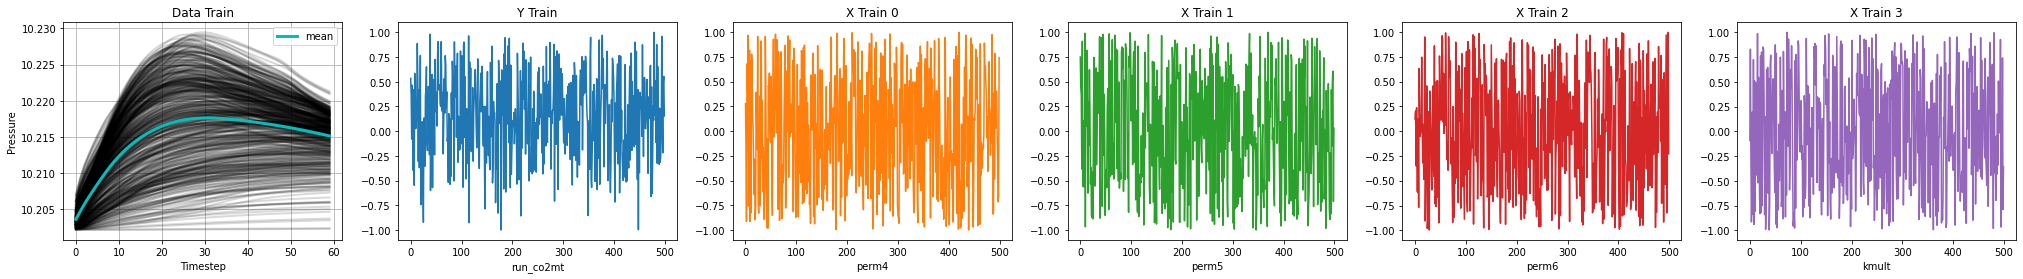

In [8]:
## Step 2: Read-in training simulation results
training_data, raw_data, parameters = read_train_sim_results(Data_Directory, MeasureType, Obj_filename, nColumn_obj, Total_time, nTimeSeries,
                                                                nColumn_data, nInterval, nTrain, nParam, x_min, x_max, titles)
#unpack variables
data_train, x_train, x_train_scaled, y_train, y_train_scaled = training_data
data_train_read_raw, data_train_read_raw0                    = raw_data
eps, nData, time_point                                       = parameters

plot_train_data(data_train, x_train_scaled, y_train_scaled, titles, MeasureType, Obj_filename, unc_params)

In [ ]:
## Step 3: 10-fold cross-validation of ROMs (iff ROMS_validation=1)
## Step 4: Construct the Mars ROMs for data and response of interest
ROM_data, ROM_obj = rom_validation(ROMs_validation, Ridge(), Ridge(), x_train_scaled, y_train, data_train, nTrain, nData, data_train_read_raw, NN=False)

In [ ]:
## Step 5: Generate Monte Carlo(MC) samples
np.random.seed(787878)
mc_design = np.random.rand(nMCSamples, nParam)
mc_design = mc_design*2 - 1
print('Generate Monte Carlo samples: Done!')

## Step 6: Evaluate the MC samples using the built ROMs for data points/objs
mc_data, mc_obj = evaluate_MC_with_ROM(ROM_data, ROM_obj, data_train_read_raw, mc_design, nData, nMCSamples)

In [ ]:
## Step 7: Calculate posterior distribution and uncertainty reduction
prior_mean, prior_p90mp10, synthetic_data, results = uncertainty_reduction(mc_obj, mc_data, ROM_data, data_train_read_raw, MeasureType,
                                                                            nData, nDataRealization, nParam, nColumn_data, 
                                                                            x_min, x_max, eps, err_option, time_sensitivity)

post_p90mp10_mean, post_p90mp10_time, post_p90mp10_iData, post_mean, post_mean_iData, nSamples, mc_obj_post = results

In [ ]:
## Step 8: Post-processing
make_post_processing(post_processing, results, synthetic_data, mc_obj, prior_p90mp10, data_train_read_raw0, time_point, Total_time, nDataRealization, nMCSamples, nColumn_data, nTimeSeries)

***
# END